In [24]:
from MLP import *
import torch
import numpy as np
import torch.nn as nn

torch.set_default_dtype(torch.float64)

seed = 4
torch.manual_seed(seed)
np.random.seed(seed)


inputs = []
n = 32

train_num = 10000
train_id = np.random.choice(2**n, train_num)
#for i in range(2**n):
for i in train_id:
    string = "{0:b}".format(i)
    sample = [int(string[i]) for i in range(len(string))]
    sample = (n - len(sample)) * [0] + sample
    inputs.append(sample)
   
inputs = np.array(inputs).astype(np.float64)
label2 = np.sum(inputs[:,[2,3]], axis=1)[:,None] % 2
label1 = np.sum(inputs[:,[0,1]], axis=1)[:,None] % 2
labels = np.concatenate([label1, label2], axis=1)

sparsity = 0.05
mask_num = int(train_num*(1-sparsity))

inputs = torch.tensor(inputs)
labels = torch.tensor(labels)

mask = torch.ones(train_num, 2)
mask[:mask_num, 1] *= 0. 

num = inputs.shape[0]
ratio = 1.0
train_num = int(num*ratio)
train_id = np.random.choice(num, train_num, replace=False)
test_id = list(set(range(num)) - set(train_id))

dataset = {}
dataset['train_input'] = inputs[train_id]
dataset['test_input'] = inputs[train_id]
dataset['train_label'] = labels[train_id]
dataset['test_label'] = labels[train_id]

width = [n, 50, 2]
model = MLP(width=width, seed=seed)
depth = len(width) - 1

def train_acc1():
    return torch.mean(((model(dataset['train_input']) > 0.5) == dataset['train_label']).float()[:,0])

def train_acc2():
    return torch.mean(((model(dataset['train_input']) > 0.5) == dataset['train_label']).float()[:,1])

def train_acc3():
    return torch.mean(((model(dataset['train_input']) > 0.5) == dataset['train_label']).float()[:,2])


results = model.fit(dataset, lamb=0e-4, opt='Adam', lr=1e-3, batch=-1, steps=1000, mask=mask, metrics=[train_acc1, train_acc2], display_metrics=['train_loss', 'train_acc1', 'train_acc2'], save_ckpt=False);

 train_loss: 3.66e-01 | train_acc1: 5.20e-01 | train_acc2: 4.96e-01 |:   2%| | 17/1000 [00:00<00:05,

using full batch


 train_loss: 1.02e-02 | train_acc1: 1.00e+00 | train_acc2: 1.00e+00 |: 100%|█| 1000/1000 [00:05<00:0


(0.0, 1000.0)

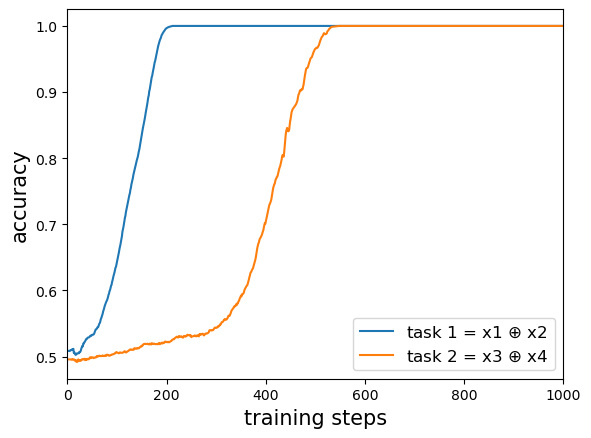

In [25]:
import matplotlib.pyplot as plt
plt.plot(results['train_acc1'])
plt.plot(results['train_acc2'])
plt.xlabel('training steps', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend([r'task 1 = x1 $\oplus$ x2', r'task 2 = x3 $\oplus$ x4'], fontsize=12, loc='lower right')
plt.xlim(0,1000)

In [26]:
import numpy as np
np.savez('./results/sp_mech_p1_0.05', **results)

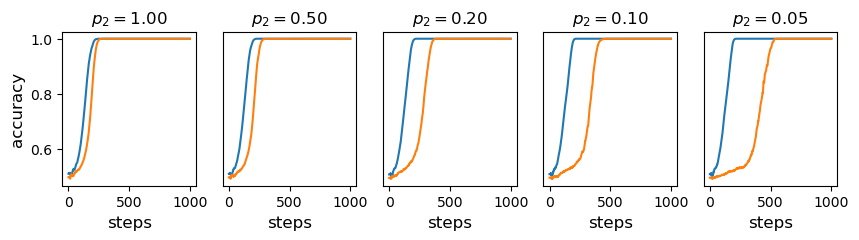

In [38]:
ps = ['1.00', '0.50', '0.20', '0.10', '0.05']

plt.figure(figsize=(10,2))

for i in range(5):

    plt.subplot(1,5,i+1)
    data = np.load('./results/sp_mech_p1_{}.npz'.format(ps[i]))
    mydict = dict(data)
    acc1 = mydict['train_acc1']
    acc2 = mydict['train_acc2']
    plt.plot(acc1)
    plt.plot(acc2)
    
    if i > 0:
        plt.yticks([])
        
    plt.title(r'$p_2={}$'.format(ps[i]))
    plt.xlabel('steps', fontsize=12)
    
    if i == 0:
        plt.ylabel('accuracy', fontsize=12)
        
plt.savefig('./plot/sp_2task_change_p2.pdf', bbox_inches='tight')